# Estratégia Baseada em Momentum

O foco desse estudo é o de realizar o backtesting, utilizando as ações da Vale ADR, de uma estratégia baseada em *time series momentum*


In [137]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [162]:
import requests
import pandas as pd
import numpy as np
from io import StringIO

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=VALE&interval=1min&apikey=F3N5MR6RBA5TWYN9&datatype=csv&outputsize=full'
r = requests.get(url)

csv_file = StringIO(r.text)  # transforma a resposta do request em um arquivo csv

df = pd.read_csv(csv_file)  # lê csv com pandas

In [172]:
df

,timestamp,open,high,low,close,volume
0,2023-06-16 18:54:00,14.45,14.45,14.45,14.45,200
1,2023-06-16 18:27:00,14.44,14.44,14.44,14.44,247
2,2023-06-16 18:07:00,14.43,14.43,14.43,14.43,359
3,2023-06-16 17:25:00,14.45,14.45,14.45,14.45,105
4,2023-06-16 17:04:00,14.45,14.45,14.45,14.45,250
...,...,...,...,...,...,...
4539,2023-06-05 05:15:00,13.80,13.80,13.80,13.80,2000
4540,2023-06-05 05:09:00,13.80,13.80,13.80,13.80,1250
4541,2023-06-05 04:56:00,13.80,13.80,13.80,13.80,195
4542,2023-06-05 04:54:00,13.80,13.80,13.80,13.80,900


In [170]:
horas = list()

for data in df['timestamp']:  # iterando a coluna de datas
    if data[:data.find(' ')] == '2023-06-16':  # selecionando apenas os dados do dia 16/06/23
      horas.append(data[data.find(' ')+1:])

horas = horas[::-1]  # invertendo a lista para ficar cronologicamente certo

In [169]:
fechamentos = list()

for index, row in df.iterrows():  # iterando linha a linha
  if row['timestamp'].startswith('2023-06-16'):  # selecionando apenas os dados do dia 16/06/23
    fechamentos.append(row['close'])

fechamentos = fechamentos[::-1]  # invertendo a lista para coincidir o preço com as horas

In [173]:
vale_intra = {'Hora':horas, 'Fechamento':fechamentos}


vale_df = pd.DataFrame(vale_intra)  # criando o dataframe com os dados necessários
vale_df = vale_df.set_index('Hora')  # definindo as horas como índice

vale_df

,Fechamento
Hora,
04:04:00,14.45
04:09:00,14.53
04:44:00,14.48
05:15:00,14.50
05:17:00,14.50
...,...
17:04:00,14.45
17:25:00,14.45
18:07:00,14.43


<Axes: xlabel='Hora'>

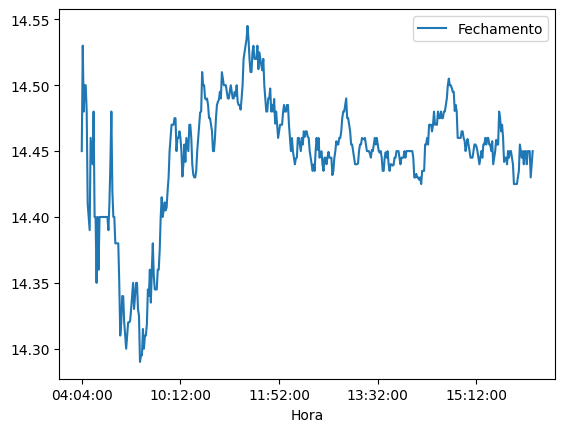

In [176]:
vale_df.plot()  # plotando os preços de fechamento

In [186]:
# Calculando log-retornos

vale_df['Retorno'] = np.log(vale_df['Fechamento']/vale_df['Fechamento'].shift(1))

<Axes: title={'center': 'Vale - 15 de Junho de 2023'}, xlabel='Hora'>

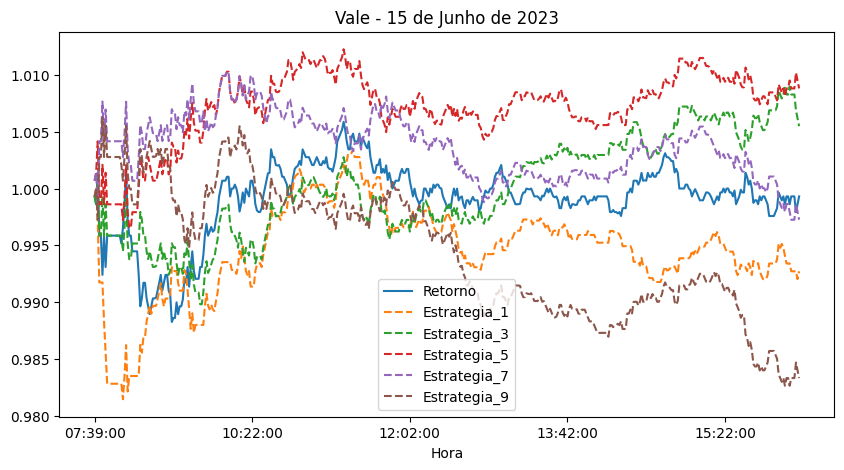

In [195]:
# Testa a estratégia para diferentes períodos

for i in [1, 3, 5, 7, 9]:
    vale_df['Posicao_%d' % i] = np.sign(vale_df['Retorno'].rolling(i).mean())  # sinal de entrada para cada um dos períodos
    vale_df['Estrategia_%d' % i] = vale_df['Posicao_%d' % i ].shift(1) * vale_df['Retorno']  # retorno da estratégia para cada um dos períodos

vale_df[['Retorno', 'Estrategia_1', 'Estrategia_3', 'Estrategia_5', 'Estrategia_7', 'Estrategia_9']].dropna().cumsum().apply(np.exp).plot(title='Vale - 15 de Junho de 2023',
                                                           figsize=(10,5),
                                                           style=['-','--','--','--','--','--'])  # plotando o retorno da ação e das estratégias